In [8]:
import os
import pandas as pd
from scipy.io import arff
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from additional_functions import (
    add_random_text_column,
    imitate_missing_values_exclude_datetime,
    introduce_missing_values_to_object_column
)
from data_preprocessing import (
    missing_values_handling,
    outlier_detection,
    impute_datawig,
    impute_and_encode_MICE,
    encode_data,
    outlier_detection,
    detect_outliers_ocsvm,
    detect_outliers_lof,
    detect_outliers_iforest,
    detect_outliers_autoencoder
)
from data_preprocessing_default import process_data
from data_preprocessing import (
    interpolate_and_fill,
    spline_interpolate_with_text_fill,
    enhanced_locf_imputation,
    rnn_impute,
    label_encoding
)
import glob
from sklearn.metrics import accuracy_score, classification_report

In [5]:
def convert_outlier_to_numeric(df1,df2):
    dftr = df1.copy()
    dfte = df2.copy()
    dftr['outlier'] = dftr['outlier'].map({"b'no'": 0, "b'yes'": 1})
    dfte['outlier'] = dfte['outlier'].map({"b'no'": 0, "b'yes'": 1})
    return dftr, dfte

In [6]:
def evaluate_outliers_f1(directory, results_folder='cross_out_results_f1'):
    """
    Process and evaluate datasets for outlier detection, recording both training and testing F1 scores.

    Args:
        directory (str): Path to the directory containing CSV files.
        results_folder (str): Directory to save the results.

    Returns:
        None
    """
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)

    for filepath in glob.glob(os.path.join(directory, '*.csv')):
        filename = os.path.basename(filepath)
        results_path = os.path.join(results_folder, filename.replace('.csv', '_results.csv'))
        df_train, df_test, y_column_name, date_col = process_data(train_input=filepath, test_input=None, separator=',', na_values='?', target_var=None, data_type='cross')
        df_train, df_test = convert_outlier_to_numeric(df_train, df_test)
        X_train_enc, X_test_enc = encode_data(df_train, df_test, y_column_name)
        X_train_mis, X_test_mis = missing_values_handling(X_train_enc, X_test_enc, date_col)
        methods = {
            'ocsvm': detect_outliers_ocsvm,
            'lof': detect_outliers_lof,
            'iforest': detect_outliers_iforest,
            'autoencoder': detect_outliers_autoencoder
        }
        results = {}
        for method_name, method_function in methods.items():
            X_train_out, X_test_out = method_function(X_train_mis, X_test_mis)
            y_train_pred = (X_train_out.iloc[:, -1] > 0).astype(int)
            y_train_true = X_train_out['outlier'].astype(int)
            train_report = classification_report(y_train_true, y_train_pred, output_dict=True, zero_division=0)
            y_test_pred = (X_test_out.iloc[:, -1] > 0).astype(int)
            y_test_true = X_test_out['outlier'].astype(int)
            test_report = classification_report(y_test_true, y_test_pred, output_dict=True, zero_division=0)
            results[method_name] = {
                'train_f1': train_report['macro avg']['f1-score'],
                'test_f1': test_report['macro avg']['f1-score']
            }
        results_df = pd.DataFrame(results).T
        results_df.to_csv(results_path)
        print(f"Results for {filename} saved to {results_path}")

evaluate_outliers_f1('out_datasets_csv')

310/310 [==============================] - 0s 555us/step
Results for ALOI_withoutdupl_norm.csv saved to cross_out_results_f1\ALOI_withoutdupl_norm_results.csv
2/2 [==============================] - 0s 999us/step
Results for Glass_withoutdupl_norm.csv saved to cross_out_results_f1\Glass_withoutdupl_norm_results.csv
3/3 [==============================] - 0s 1ms/step
Results for Ionosphere_withoutdupl_norm.csv saved to cross_out_results_f1\Ionosphere_withoutdupl_norm_results.csv
301/301 [==============================] - 0s 547us/step
Results for KDDCup99_withoutdupl_norm_idf.csv saved to cross_out_results_f1\KDDCup99_withoutdupl_norm_idf_results.csv
1/1 [==============================] - 0s 15ms/step
Results for Lymphography_withoutdupl_norm_idf.csv saved to cross_out_results_f1\Lymphography_withoutdupl_norm_idf_results.csv
62/62 [==============================] - 0s 551us/step
Results for PenDigits_withoutdupl_norm_v10.csv saved to cross_out_results_f1\PenDigits_withoutdupl_norm_v10_res

In [9]:
def evaluate_outliers_accuracy(directory, results_folder='cross_out_results_accuracy'):
    """
    Process and evaluate datasets for outlier detection, recording both training and testing accuracy.

    Args:
        directory (str): Path to the directory containing CSV files.
        results_folder (str): Directory to save the results.

    Returns:
        None
    """
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)

    for filepath in glob.glob(os.path.join(directory, '*.csv')):
        filename = os.path.basename(filepath)
        results_path = os.path.join(results_folder, filename.replace('.csv', '_results.csv'))
        df_train, df_test, y_column_name, date_col = process_data(
            train_input=filepath, test_input=None, separator=',', na_values='?', target_var=None, data_type='cross')
        df_train, df_test = convert_outlier_to_numeric(df_train, df_test)
        X_train_enc, X_test_enc = encode_data(df_train, df_test, y_column_name)
        X_train_mis, X_test_mis = missing_values_handling(X_train_enc, X_test_enc, date_col)

        methods = {
            'ocsvm': detect_outliers_ocsvm,
            'lof': detect_outliers_lof,
            'iforest': detect_outliers_iforest,
            'autoencoder': detect_outliers_autoencoder
        }

        results = {}
        for method_name, method_function in methods.items():
            X_train_out, X_test_out = method_function(X_train_mis, X_test_mis)
            y_train_true = X_train_out['outlier'].astype(int)
            y_train_pred = (X_train_out.iloc[:, -1] > 0).astype(int)
            train_accuracy = accuracy_score(y_train_true, y_train_pred)
            y_test_true = X_test_out['outlier'].astype(int)
            y_test_pred = (X_test_out.iloc[:, -1] > 0).astype(int)
            test_accuracy = accuracy_score(y_test_true, y_test_pred)

            results[method_name] = {
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy
            }
        
        results_df = pd.DataFrame(results).T
        results_df.to_csv(results_path)
        print(f"Results for {filename} saved to {results_path}")

evaluate_outliers_accuracy('out_datasets_csv')

310/310 [==============================] - 0s 519us/step
Results for ALOI_withoutdupl_norm.csv saved to cross_out_results_accuracy\ALOI_withoutdupl_norm_results.csv
2/2 [==============================] - 0s 997us/step
Results for Glass_withoutdupl_norm.csv saved to cross_out_results_accuracy\Glass_withoutdupl_norm_results.csv
3/3 [==============================] - 0s 997us/step
Results for Ionosphere_withoutdupl_norm.csv saved to cross_out_results_accuracy\Ionosphere_withoutdupl_norm_results.csv
301/301 [==============================] - 0s 553us/step
Results for KDDCup99_withoutdupl_norm_idf.csv saved to cross_out_results_accuracy\KDDCup99_withoutdupl_norm_idf_results.csv
1/1 [==============================] - 0s 14ms/step
Results for Lymphography_withoutdupl_norm_idf.csv saved to cross_out_results_accuracy\Lymphography_withoutdupl_norm_idf_results.csv
62/62 [==============================] - 0s 542us/step
Results for PenDigits_withoutdupl_norm_v10.csv saved to cross_out_results_accur

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

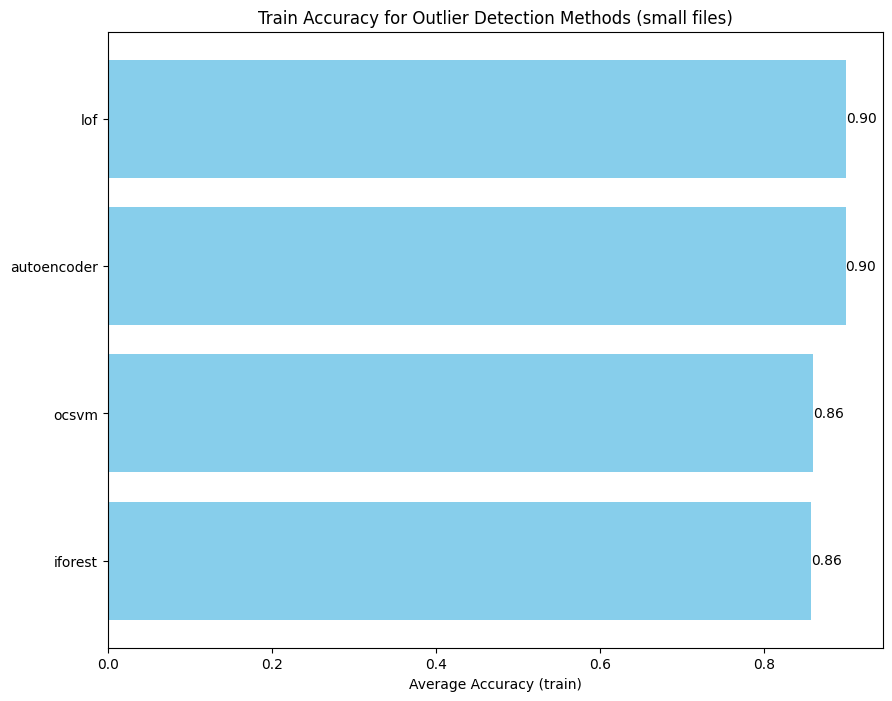

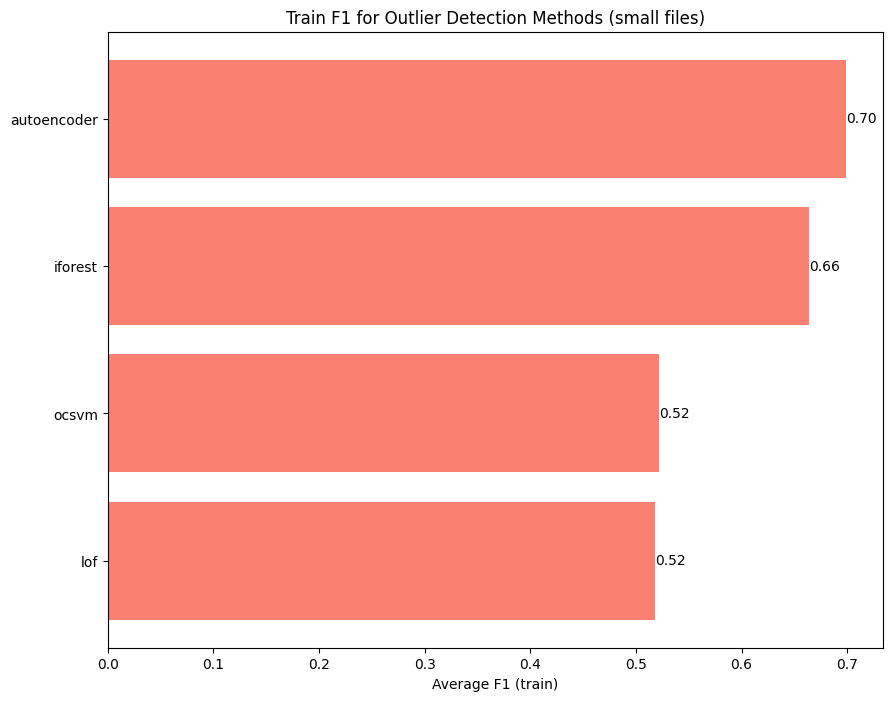

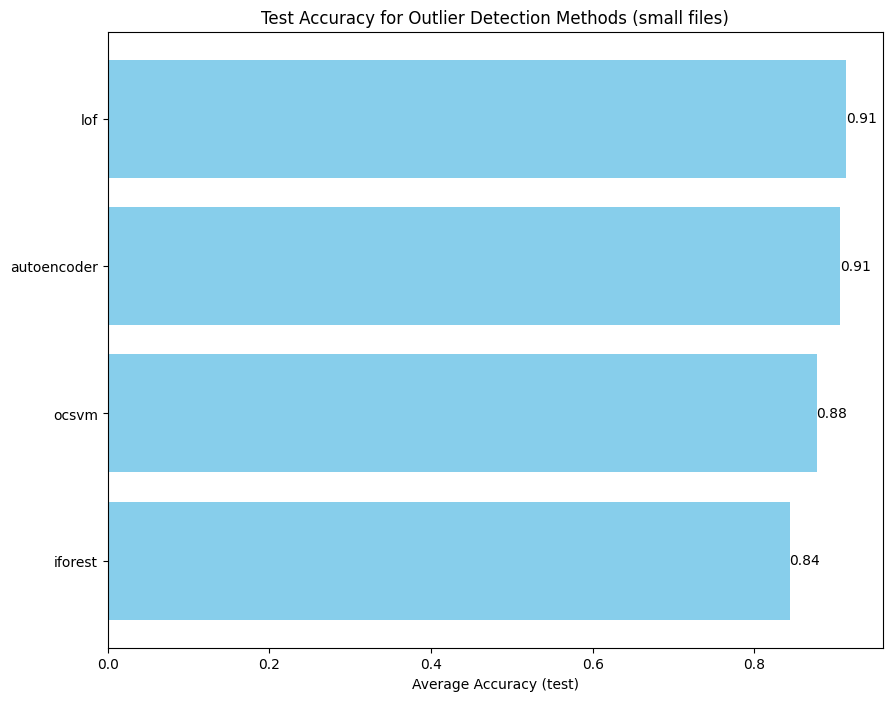

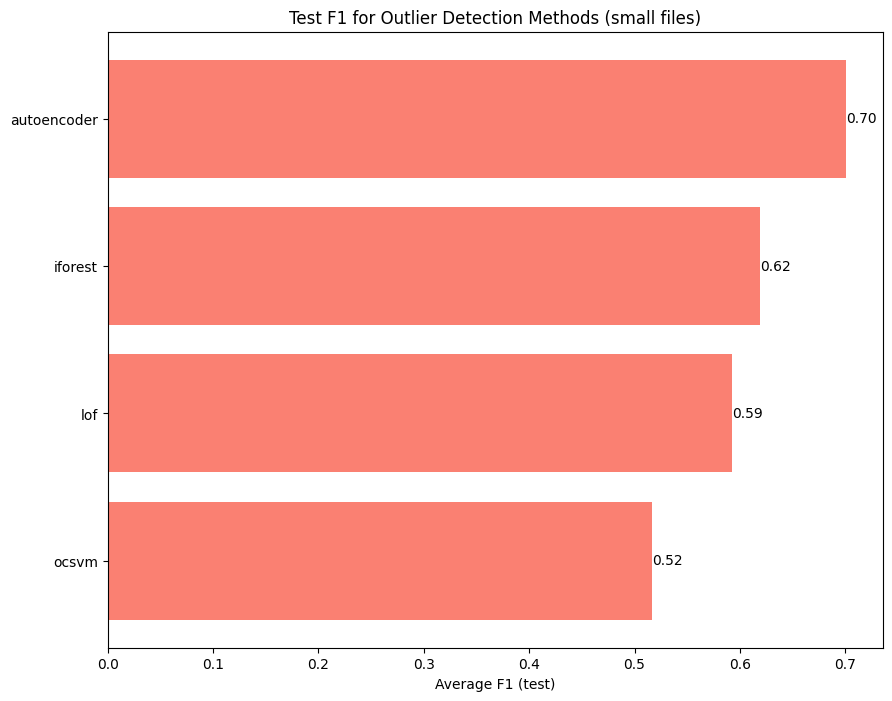

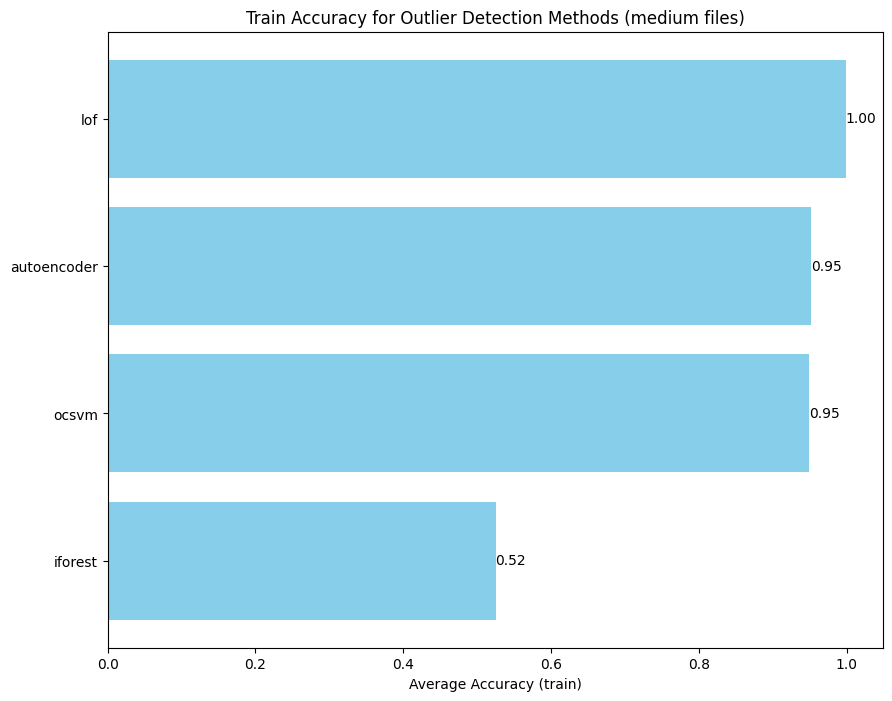

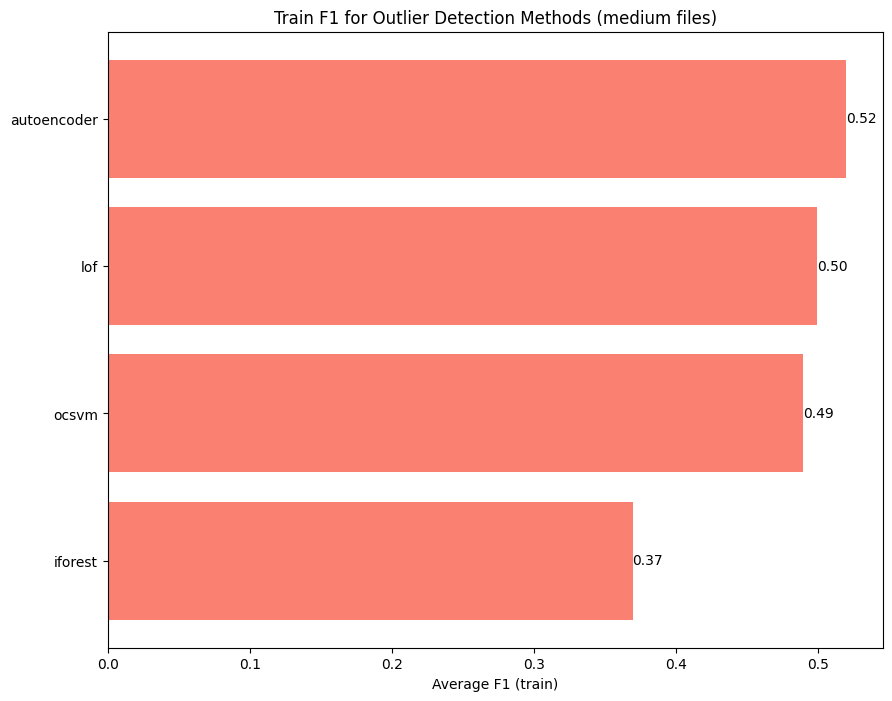

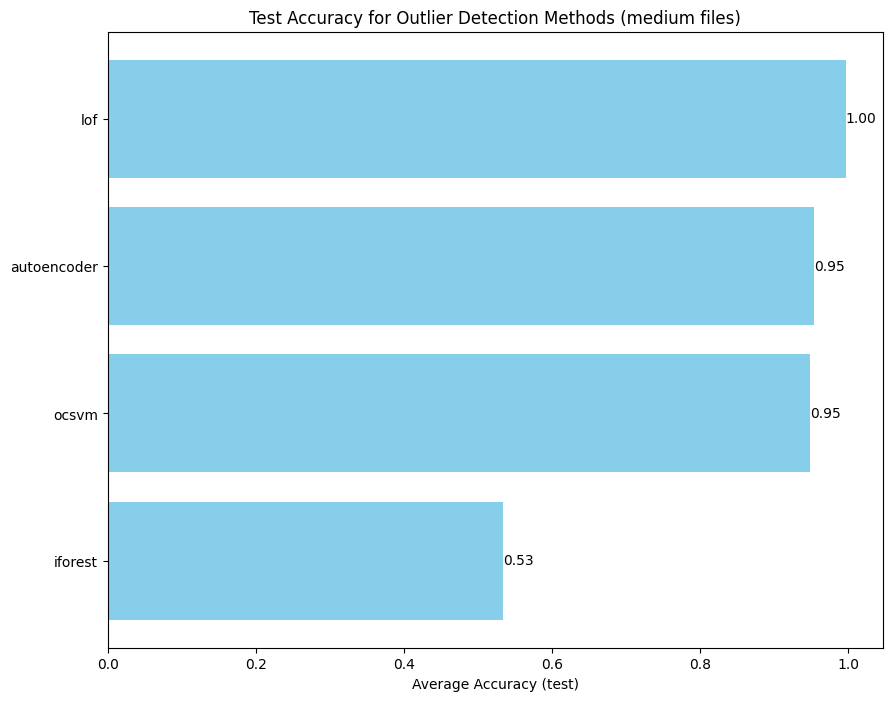

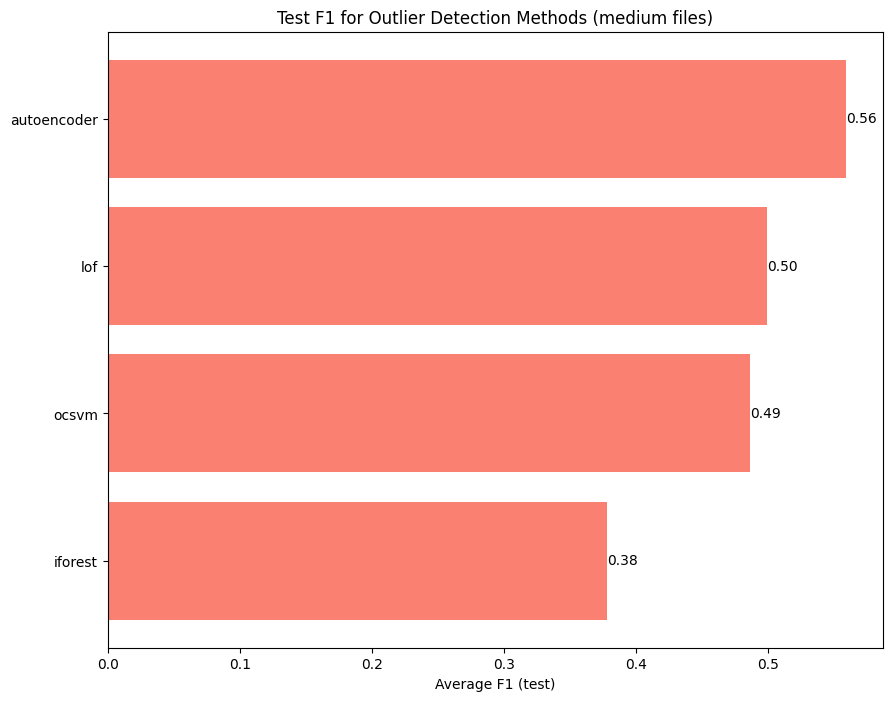

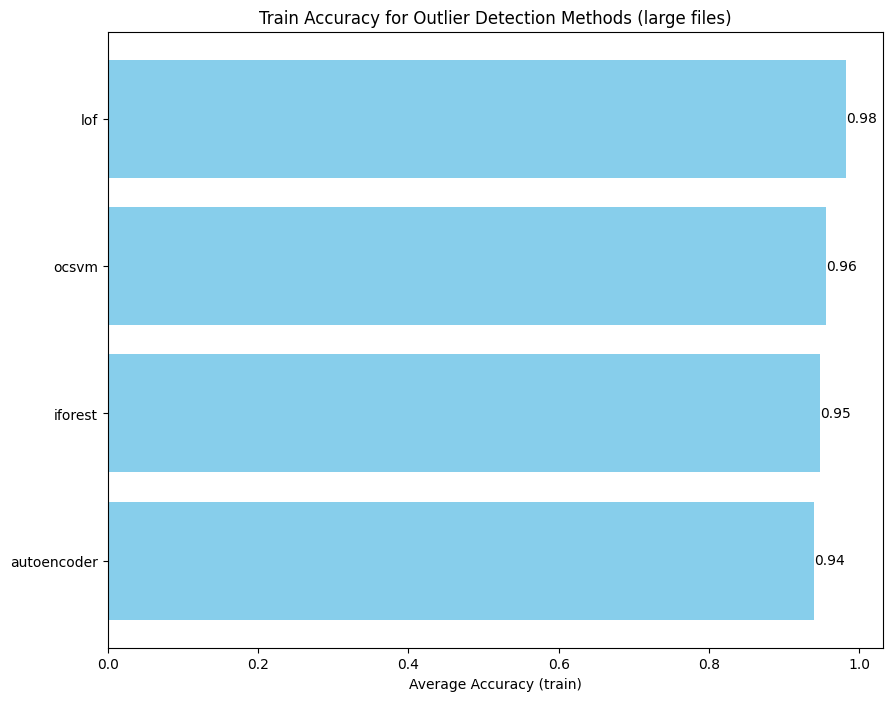

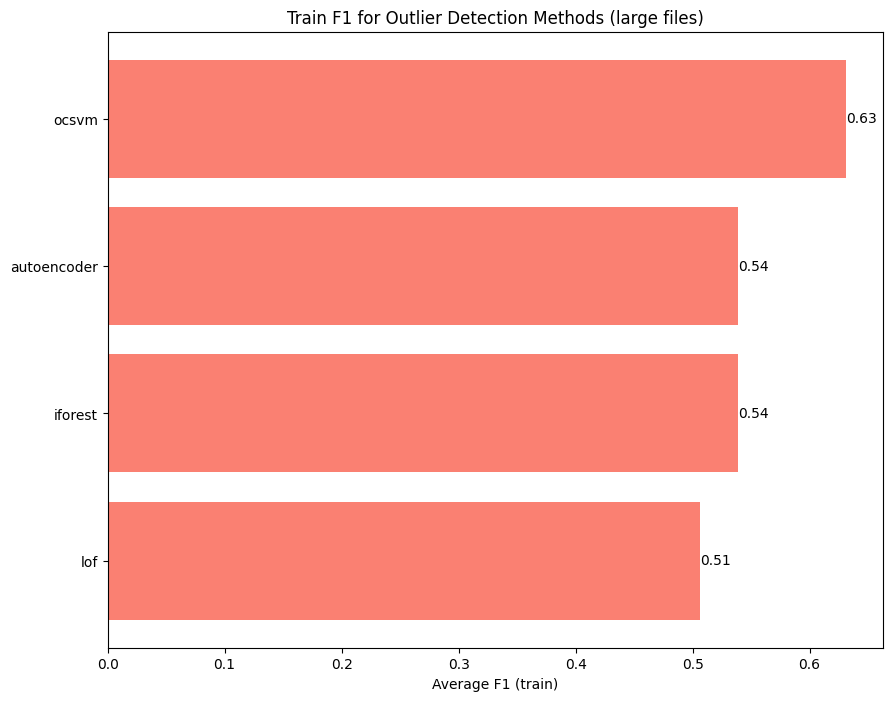

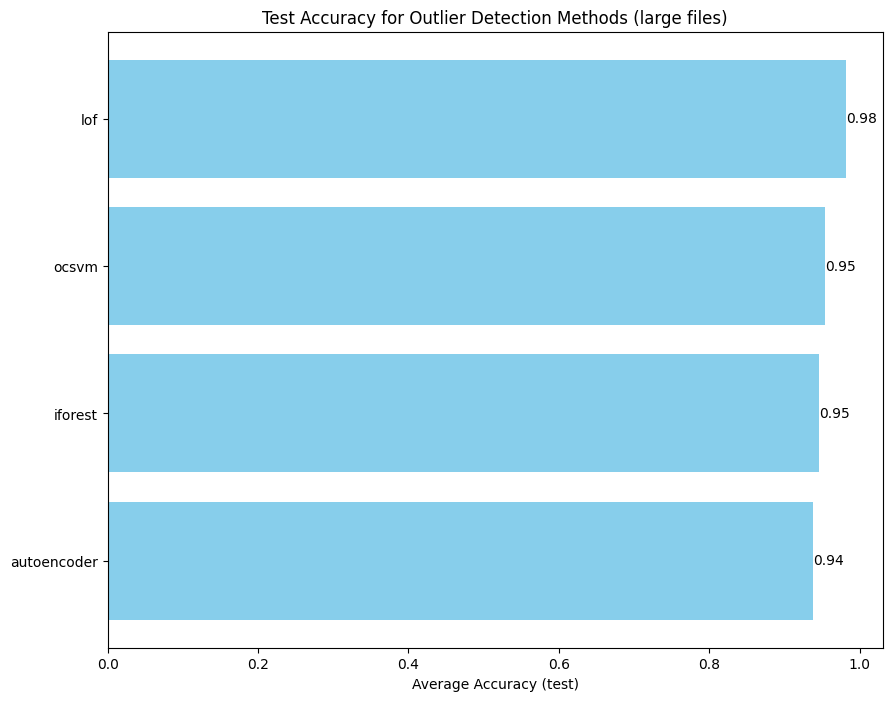

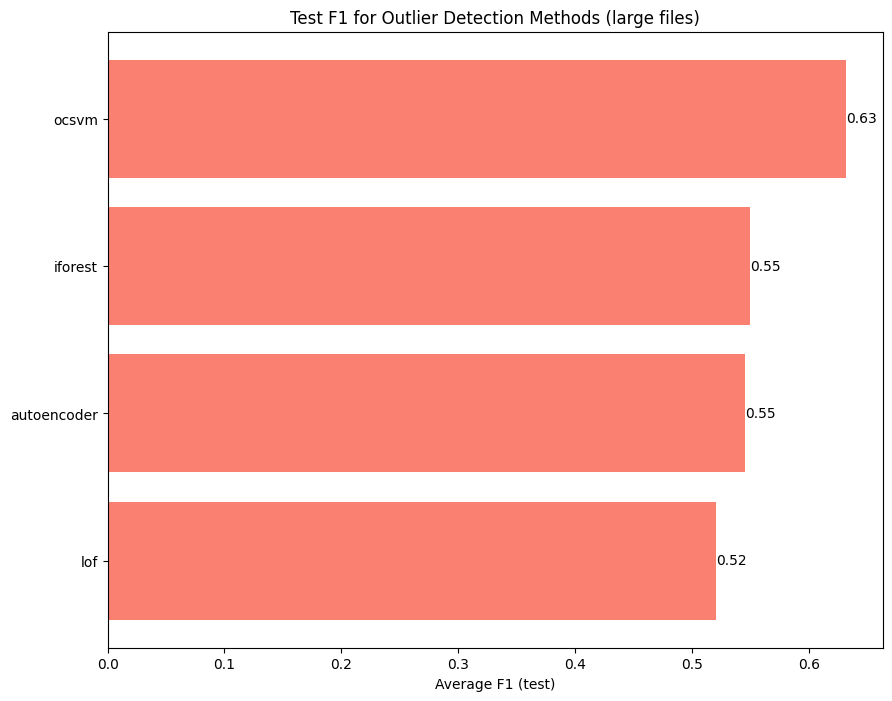

In [11]:
def get_size_category(size):
    if size < 0.5 * 1024 * 1024:  # Smaller than 0.5MB
        return 'small'
    elif size < 5 * 1024 * 1024:  # Smaller than 5MB
        return 'medium'
    else:  # Larger files up to 25MB
        return 'large'

def plot_results(data_folder, results_folder_accuracy, results_folder_f1):
    original_files = glob.glob(os.path.join(data_folder, '*.csv'))
    results = {'small': {}, 'medium': {}, 'large': {}}
    
    for file in original_files:
        base_name = os.path.basename(file)
        file_size = os.path.getsize(file)
        size_category = get_size_category(file_size)
        result_path_accuracy = os.path.join(results_folder_accuracy, base_name.replace('.csv', '_results.csv'))
        result_path_f1 = os.path.join(results_folder_f1, base_name.replace('.csv', '_results.csv'))
        if os.path.exists(result_path_accuracy) and os.path.exists(result_path_f1):
            df_accuracy = pd.read_csv(result_path_accuracy, index_col=0)
            df_f1 = pd.read_csv(result_path_f1, index_col=0)
            for method in df_accuracy.index:
                if method not in results[size_category]:
                    results[size_category][method] = {
                        'train_accuracy': [],
                        'test_accuracy': [],
                        'train_f1': [],
                        'test_f1': []
                    }
                results[size_category][method]['train_accuracy'].append(df_accuracy.at[method, 'train_accuracy'])
                results[size_category][method]['test_accuracy'].append(df_accuracy.at[method, 'test_accuracy'])
                results[size_category][method]['train_f1'].append(df_f1.at[method, 'train_f1'])
                results[size_category][method]['test_f1'].append(df_f1.at[method, 'test_f1'])
        else:
            print(f"Missing results for {base_name}")
    for size_category in ['small', 'medium', 'large']:
        for dataset_type in ['train', 'test']:
            for metric in ['accuracy', 'f1']:
                plot_data = {method: np.mean(values[f"{dataset_type}_{metric}"]) for method, values in results[size_category].items()}
                if plot_data:
                    plt.figure(figsize=(10, 8))
                    methods, scores = zip(*sorted(plot_data.items(), key=lambda x: x[1], reverse=True))
                    plt.barh(methods, scores, color='skyblue' if metric == 'accuracy' else 'salmon')
                    plt.xlabel(f'Average {metric.capitalize()} ({dataset_type})')
                    plt.title(f'{dataset_type.capitalize()} {metric.capitalize()} for Outlier Detection Methods ({size_category} files)')
                    plt.gca().invert_yaxis()
                    for index, value in enumerate(scores):
                        plt.text(value, index, f'{value:.2f}', ha='left', va='center')
                    plt.show()
                else:
                    print(f"No data available for {dataset_type} {metric} in {size_category} size category.")

plot_results('out_datasets_csv', 'cross_out_results_accuracy', 'cross_out_results_f1')

In [12]:
def print_results(data_folder, results_folder_accuracy, results_folder_f1):
    original_files = glob.glob(os.path.join(data_folder, '*.csv'))
    results = {'small': {}, 'medium': {}, 'large': {}}
    for file in original_files:
        base_name = os.path.basename(file)
        file_size = os.path.getsize(file)
        size_category = get_size_category(file_size)
        result_path_accuracy = os.path.join(results_folder_accuracy, base_name.replace('.csv', '_results.csv'))
        result_path_f1 = os.path.join(results_folder_f1, base_name.replace('.csv', '_results.csv'))
        if os.path.exists(result_path_accuracy) and os.path.exists(result_path_f1):
            df_accuracy = pd.read_csv(result_path_accuracy, index_col=0)
            df_f1 = pd.read_csv(result_path_f1, index_col=0)
            for method in df_accuracy.index:
                if method not in results[size_category]:
                    results[size_category][method] = {
                        'train_accuracy': [],
                        'test_accuracy': [],
                        'train_f1': [],
                        'test_f1': []
                    }   
                results[size_category][method]['train_accuracy'].append(df_accuracy.at[method, 'train_accuracy'])
                results[size_category][method]['test_accuracy'].append(df_accuracy.at[method, 'test_accuracy'])
                results[size_category][method]['train_f1'].append(df_f1.at[method, 'train_f1'])
                results[size_category][method]['test_f1'].append(df_f1.at[method, 'test_f1'])
        else:
            print(f"Missing results for {base_name}")
    for size_category in ['small', 'medium', 'large']:
        for method, values in results[size_category].items():
            print(f"Results for {method} ({size_category} size category):")
            for metric, scores in values.items():
                print(f"  {metric}: {np.mean(scores)}")
            print()

print_results('out_datasets_csv', 'cross_out_results_accuracy', 'cross_out_results_f1')

Results for ocsvm (small size category):
  train_accuracy: 0.8598251840605621
  test_accuracy: 0.8768362838903809
  train_f1: 0.5215261330969772
  test_f1: 0.5164489784324883

Results for lof (small size category):
  train_accuracy: 0.8996638855151311
  test_accuracy: 0.9129260404689892
  train_f1: 0.5182389932923457
  test_f1: 0.5925027607722504

Results for iforest (small size category):
  train_accuracy: 0.8576548843641316
  test_accuracy: 0.8434706067505633
  train_f1: 0.6639286834826191
  test_f1: 0.6195079015104941

Results for autoencoder (small size category):
  train_accuracy: 0.8995594817001434
  test_accuracy: 0.9061314065092746
  train_f1: 0.6985272644849554
  test_f1: 0.700359410195255

Results for ocsvm (medium size category):
  train_accuracy: 0.9488218900430708
  test_accuracy: 0.9483282674772036
  train_f1: 0.4893308217076705
  test_f1: 0.4867394695787831

Results for lof (medium size category):
  train_accuracy: 0.9983531796300988
  test_accuracy: 0.99645390070922
  t